# A Guide On Solving Non-Convex Consumption-Saving Models

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
  - 1.1. [Install NLopt](#toc1_1_)    
  - 1.2. [Choose number of threads in numba](#toc1_2_)    
- 2. [Timing function](#toc2_)    
- 3. [Settings](#toc3_)    
- 4. [Compiling C++](#toc4_)    
- 5. [Timings](#toc5_)    
- 6. [Tables](#toc6_)    
- 7. [Figures](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook produces the timing and accuracy results for the benchmark model in [A Guide to Solve Non-Convex Consumption-Saving Models](https://doi.org/10.1007/s10614-020-10045-x).

**Computer used for timings:** Windows 10 computer with 2x Intel(R) Xeon(R) Gold 6254 3.10 GHz CPUs (18 cores, 36 logical processes each) and 768 GB of RAM.

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

### 1.1. <a id='toc1_1_'></a>[Install NLopt](#toc0_)

In [2]:
import consav
consav.cpptools.setup_nlopt()

### 1.2. <a id='toc1_2_'></a>[Choose number of threads in numba](#toc0_)

In [3]:
import numba as nb
nb.set_num_threads(8)

## 2. <a id='toc2_'></a>[Timing function](#toc0_)

In [4]:
def run(name = 'baseline',
        rep = 1, # set to 5 in the paper
        load = False,
        solmethod = 'negm_cpp',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    cpp_solmethods = ['vfi_cpp','nvfi_cpp','negm_cpp']
    if load == False:
        
        # i. precompile
        if '_cpp' in solmethod:
            model.link_to_cpp(force_compile=False)
        else:
            model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()    

        if '_cpp' in solmethod:
            model.cpp.delink()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

## 3. <a id='toc3_'></a>[Settings](#toc0_)

In [5]:
load = False
load_negm = load
load_negm_cpp = load
load_negm_cpp_simple = load
load_nvfi = load
load_nvfi_cpp = load
load_nvfi_cpp_simple = load
load_vfi = load
load_vfi_cpp = load

T = 50
models = dict()

# baseline
basename = 'results'
base = dict()
base['Np'] = 150
base['Nn'] = 150
base['Nm'] = 300
base['Nx'] = 300
base['Na'] = 300
base['T'] = T

## 4. <a id='toc4_'></a>[Compiling C++](#toc0_)

In [6]:
model = DurableConsumptionModelClass(name='')
model.link_to_cpp(do_print=False)
model.cpp.delink()

## 5. <a id='toc5_'></a>[Timings](#toc0_)

In [7]:
models['negm_cpp'] = run(name=f'{basename}',load=load_negm_cpp,solmethod='negm_cpp',updpar=base)
models['negm_cpp_simple'] = run(name=f'{basename}_simple',load=load_negm_cpp_simple,solmethod='negm_cpp',do_simple_wq=True,updpar=base)
models['negm'] = run(name=f'{basename}',load=load_negm,solmethod='negm',updpar=base)

models['nvfi_cpp'] = run(name=f'{basename}',load=load_nvfi_cpp,solmethod='nvfi_cpp',updpar=base)
models['nvfi_cpp_simple'] = run(name=f'{basename}_simple',load=load_nvfi_cpp_simple,solmethod='nvfi_cpp',do_simple_wq=True,updpar=base)
models['nvfi'] = run(name=f'{basename}',load=load_nvfi,solmethod='nvfi',updpar=base)

models['vfi_cpp'] = run(name=f'{basename}',load=load_vfi_cpp,solmethod='vfi_cpp',updpar=base)

0: total time = 88.75


Name: results (solmethod = negm_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 88.8
     w: 54.7
  keep: 32.9
   adj: 1.2
Utility: -32.213469
Euler errors:
     total: -4.71 (-5.58,-3.77)
   keepers: -4.68 (-5.58,-3.72)
 adjusters: -4.89 (-5.56,-4.40)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967627
checksum, inv_v_adj: 0.03973847



0: total time = 250.04


Name: results_simple (solmethod = negm_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 250.0
     w: 216.4
  keep: 32.4
   adj: 1.2
Utility: -32.213469
Euler errors:
     total: -4.71 (-5.58,-3.77)
   keepers: -4.68 (-5.58,-3.72)
 adjusters: -4.89 (-5.56,-4.40)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967627
checksum, inv_v_adj: 0.03973847



0: total time = 102.04


Name: results (solmethod = negm)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 102.0
     w: 70.7
  keep: 29.8
   adj: 1.5
Utility: -32.213469
Euler errors:
     total: -4.71 (-5.58,-3.77)
   keepers: -4.68 (-5.58,-3.72)
 adjusters: -4.89 (-5.56,-4.40)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967627
checksum, inv_v_adj: 0.03973847



0: total time = 288.88


Name: results (solmethod = nvfi_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 288.9
     w: 32.2
  keep: 255.5
   adj: 1.1
Utility: -32.213436
Euler errors:
     total: -4.61 (-5.62,-3.70)
   keepers: -4.59 (-5.61,-3.67)
 adjusters: -4.74 (-5.69,-4.06)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967629
checksum, inv_v_adj: 0.03973852



0: total time = 361.86


Name: results_simple (solmethod = nvfi_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 361.9
     w: 106.6
  keep: 254.1
   adj: 1.1
Utility: -32.213436
Euler errors:
     total: -4.61 (-5.62,-3.70)
   keepers: -4.59 (-5.61,-3.67)
 adjusters: -4.74 (-5.69,-4.06)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967629
checksum, inv_v_adj: 0.03973852



0: total time = 335.42


Name: results (solmethod = nvfi)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 335.4
     w: 39.8
  keep: 294.1
   adj: 1.5
Utility: -32.213436
Euler errors:
     total: -4.61 (-5.62,-3.70)
   keepers: -4.59 (-5.61,-3.67)
 adjusters: -4.74 (-5.69,-4.06)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967629
checksum, inv_v_adj: 0.03973852



0: total time = 3809.88


Name: results (solmethod = vfi_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 3809.9
     w: 0.0
  keep: 3734.0
   adj: 75.9
Utility: -32.213432
Euler errors:
     total: -4.67 (-5.73,-3.69)
   keepers: -4.69 (-5.75,-3.69)
 adjusters: -4.56 (-5.60,-3.70)
Moments:
 adjuster share: 0.172
         mean c: 0.979
          var c: 0.256
         mean d: 0.562
          var d: 0.112

checksum, inv_v_keep: 0.03967636
checksum, inv_v_adj: 0.03974090



## 6. <a id='toc6_'></a>[Tables](#toc0_)

In [8]:
import tabs

In [9]:
main_models = [models['vfi_cpp'],models['nvfi_cpp_simple'],models['negm_cpp_simple'],models['nvfi_cpp'],models['negm_cpp']]
tabs.all(main_models,speedup=True)

In [10]:
main_models = [models['nvfi_cpp'],models['nvfi'],models['negm_cpp'],models['negm']]
tabs.all(main_models,postfix='_python')

## 7. <a id='toc7_'></a>[Figures](#toc0_)

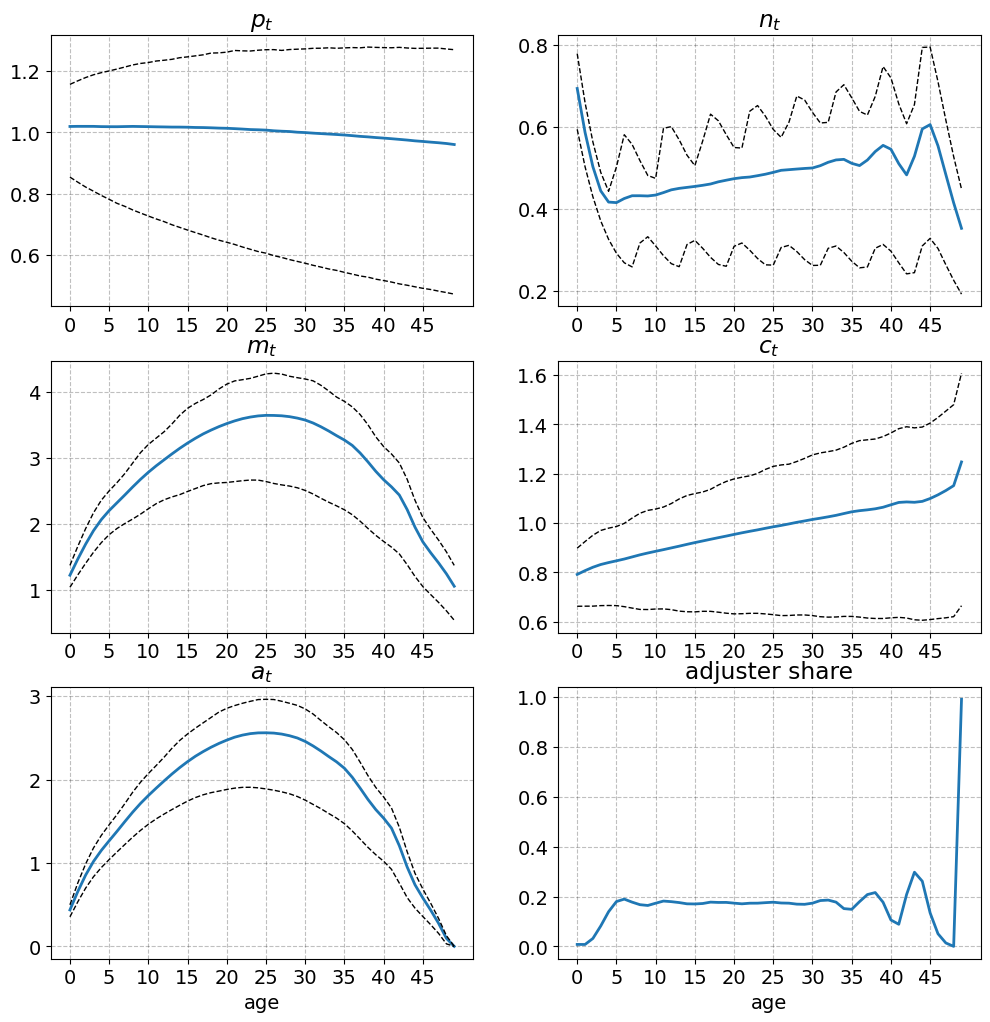

In [11]:
models['negm_cpp'].lifecycle()

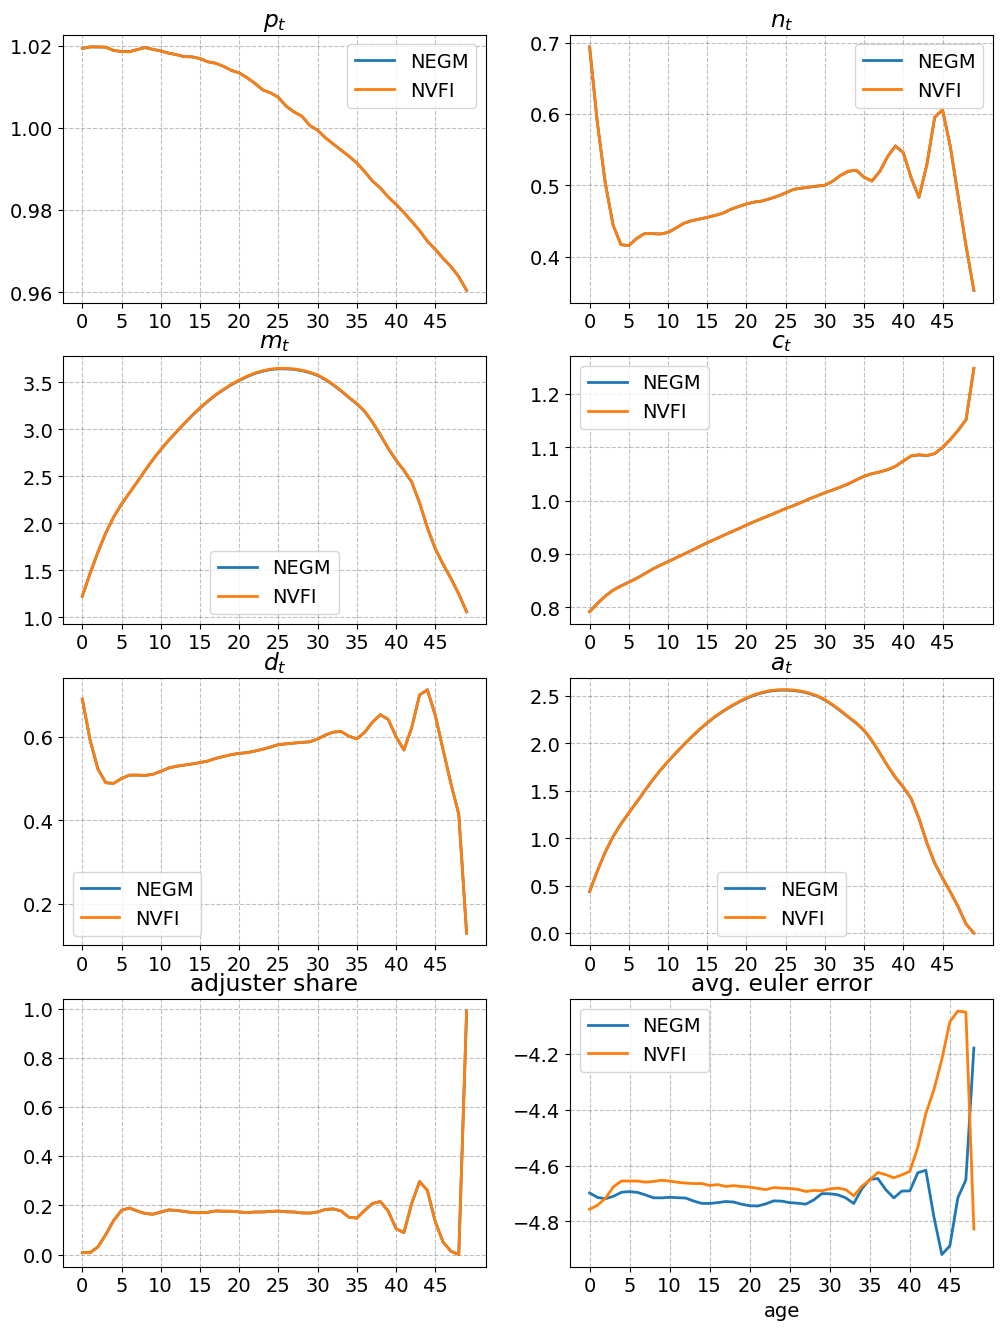

In [12]:
from figs import lifecycle_compare
lifecycle_compare(models['negm_cpp'],'NEGM',models['nvfi_cpp'],'NVFI',do_euler_errors=True)

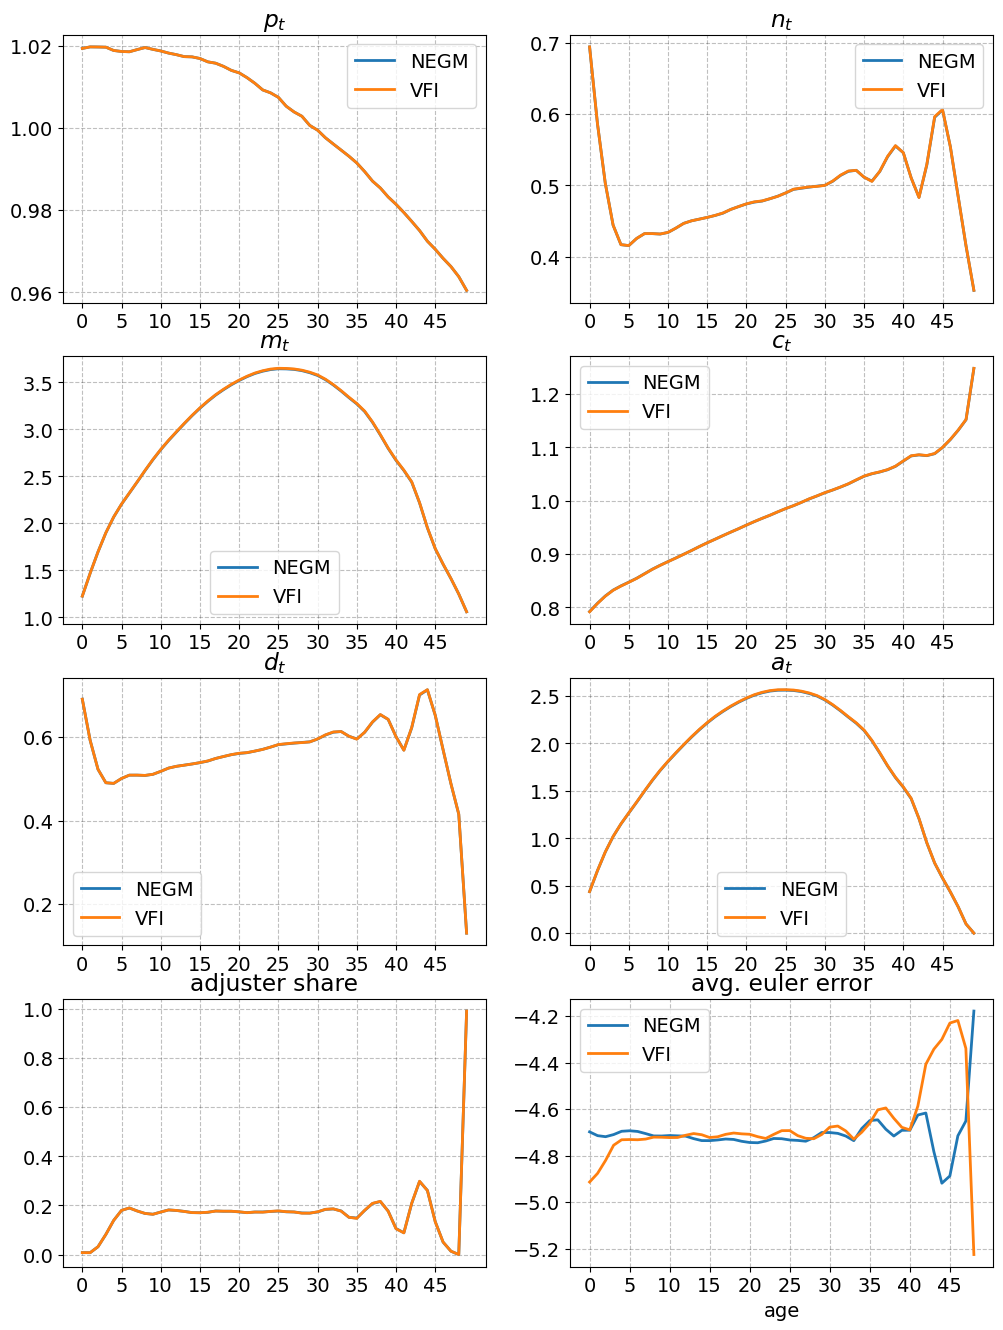

In [13]:
lifecycle_compare(models['negm_cpp'],'NEGM',models['vfi_cpp'],'VFI',do_euler_errors=True)

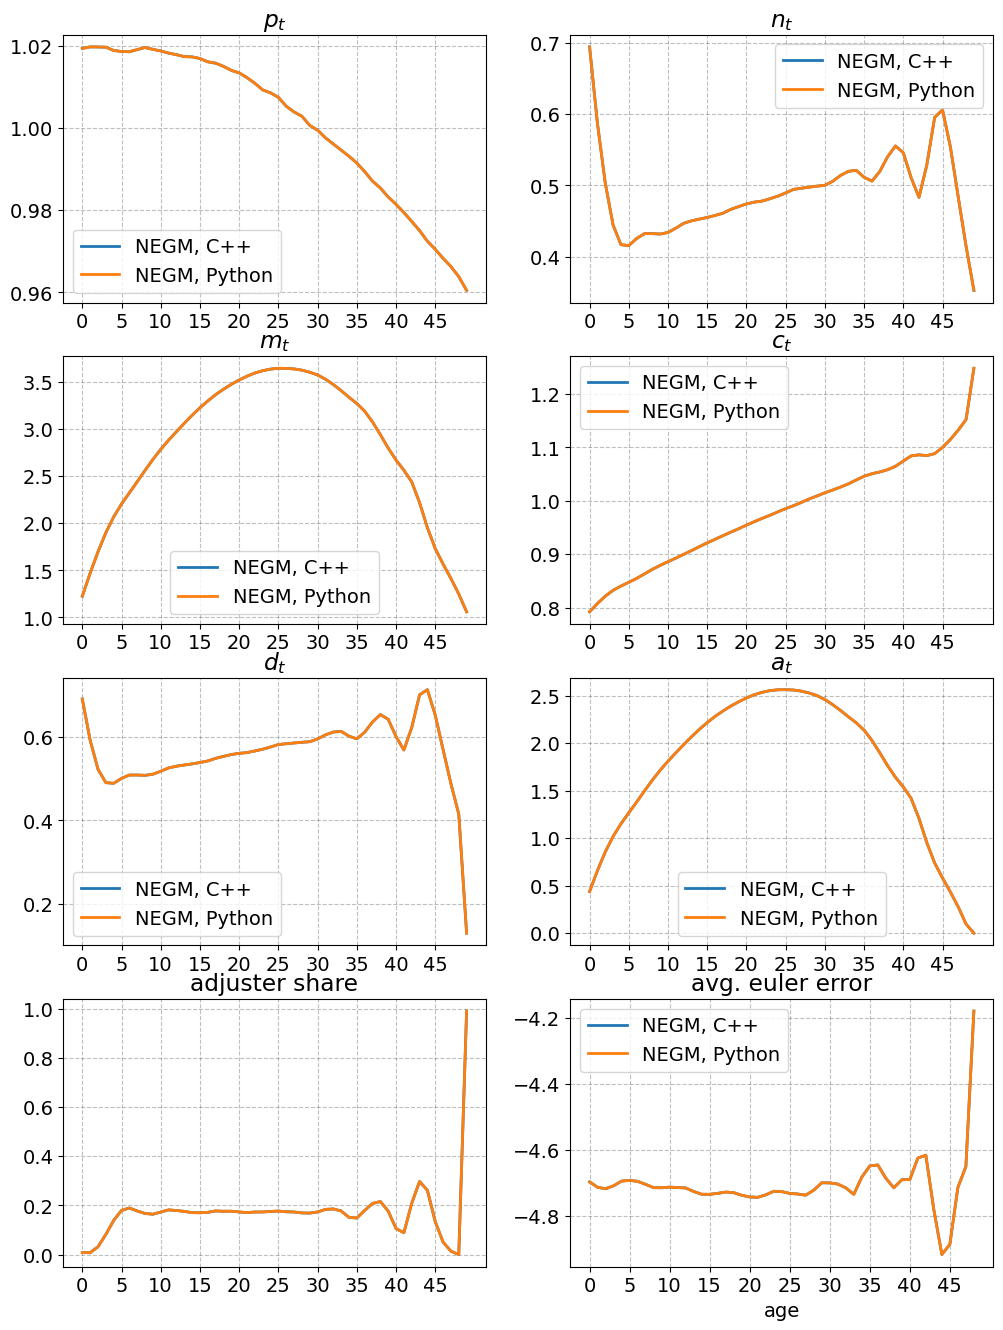

In [14]:
lifecycle_compare(models['negm_cpp'],'NEGM, C++',models['negm'],'NEGM, Python',do_euler_errors=True)